In [208]:
import pandas as pd

**What we want to do in this project is to find out which ETFs can be best used to hedge against gold. We also strive to prove our market understanding by constructing a model that predicts gold price based on its hedge ETFs.**


We will load up the dataframe

In [209]:
df = pd.read_csv("data/ETF-prices.csv")
print(df)

        fund_symbol  price_date   open   high    low  close  adj_close  volume
0               AAA  2020-09-09  25.10  25.12  25.07  25.07      24.85   17300
1               AAA  2020-09-10  25.06  25.07  25.05  25.07      24.85   23500
2               AAA  2020-09-11  25.04  25.05  25.02  25.03      24.81   33400
3               AAA  2020-09-14  25.01  25.06  25.01  25.02      24.80   13100
4               AAA  2020-09-15  25.02  25.03  25.01  25.01      24.79   12100
...             ...         ...    ...    ...    ...    ...        ...     ...
3866025         ZSL  2021-11-23  26.81  27.21  26.30  26.35      26.35  190900
3866026         ZSL  2021-11-24  26.79  26.96  26.57  26.69      26.69  109000
3866027         ZSL  2021-11-26  26.67  28.14  26.67  27.72      27.72  205500
3866028         ZSL  2021-11-29  27.89  28.56  27.80  28.27      28.27  411900
3866029         ZSL  2021-11-30  28.15  28.73  25.91  28.49      28.49  219400

[3866030 rows x 8 columns]


*A hedge against X is a strategy where one invests in an asset that usually grows as X falls and vice versa, to minimize risk and maximize profits*

We do this by selecting linear regression features among other ETF prices and determining those that have large coefficients and are statistically relevant.

Linear regression is chosen as a simple method due to its interpretability and the fact we do not need a price prediction model here - but instead to discover which ETFs to invest once we have invested in gold (a safe haven investement) to be able to hedge (minimize risk while maximizing profit).

If an ETF price has strong negative correlation that is a candidate for a hedge.

Let us take all the timestamped data and put it into a separate dataframe. We do not care for specific times because we are looking for a general hegde against an ETF. So, all the timestamps simply represent data points of price.

In [210]:
df_data = pd.concat([df["fund_symbol"], df["open"], df["price_date"]], axis=1)
df_data

,fund_symbol,open,price_date
0,AAA,25.10,2020-09-09
1,AAA,25.06,2020-09-10
2,AAA,25.04,2020-09-11
3,AAA,25.01,2020-09-14
4,AAA,25.02,2020-09-15
...,...,...,...
3866025,ZSL,26.81,2021-11-23
3866026,ZSL,26.79,2021-11-24
3866027,ZSL,26.67,2021-11-26
3866028,ZSL,27.89,2021-11-29


**Initial data exploration**

First let us look at some tickers that are known to go up when gold goes down and vice versa. Out of these we can then do feature selection.

- US bullish ETFs - it is known gold can often go down when the dollar goes up, and the dollar going down means people flock to safe haven investments

UUP <br>
USDU

- Indirect US bullish ETFs

iShares Currency Hedged MSCI EAFE ETF (HEFA)
<br>
iShares Currency Hedged MSCI Germany ETF (HEWG)
<br>
iShares Currency Hedged MSCI Japan ETF (HEWJ)
<br>
Xtrackers MSCI EAFE Hedged Equity ETF (DBEF)
<br>
- Inflation rate ETFs - as inflation goes down, people move away from safe haven investments so we can try these too

TBF ---	ProShares Short 20+ Year Treasury	<br>
TBT ---	ProShares UltraShort 20+ Year Treasury	<br>
STPP ---	iPath US Treasury Steepener ETN (less liquid) <br>
FLYT ---	U.S. Benchmark Series: US Treasury Floating Rate Bond ETF <br>
TMV ---	Direxion Daily 20+ Year Treasury Bear 3X Shares

- Market expansion ETFs - gold, being a defensive asset is used as a hedge when the economy is not expanding, so let's use tickers of ETFs that track expansion of the economy

XLF ---	Financial Select Sector SPDR Fund <br>
XLI ---	Industrial Select Sector SPDR Fund <br>
XLY ---	Consumer Discretionary Select Sector SPDR Fund <br>
IYT ---	iShares U.S. <br>



In [211]:
init_tickers = ["UUP", "USDU", "TBF", "TBT", "STPP", "FLYT", "XLF", "XLI", "XLY", "IYT", "HEFA", "HEWG", "HEWJ", "DBEF", "TMV"]


In [212]:
from functools import reduce

# Let us now make every one of these tickers a separate column
dfs = []
for ticker in init_tickers+["GLD"]:
    tmp_df = pd.DataFrame()
    tmp_df = df_data[df_data["fund_symbol"] == ticker][["open", "price_date"]]
    tmp_df.rename(columns={"open": ticker}, inplace=True)
    if len(tmp_df) == 0 or tmp_df["price_date"].iloc[0] > "2015-01-01":
        continue # we want to have enough data and not include if some tickers are missing
    dfs.append(tmp_df)
    print(tmp_df.head())


           UUP  price_date
3578747  24.93  2007-03-01
3578748  25.02  2007-03-02
3578749  25.11  2007-03-05
3578750  25.10  2007-03-06
3578751  25.08  2007-03-07
          USDU  price_date
3540764  25.04  2013-12-18
3540765  25.21  2013-12-19
3540766  25.22  2013-12-20
3540767  25.14  2013-12-23
3540768  25.13  2013-12-24
           TBF  price_date
3328254  49.30  2009-08-20
3328255  49.28  2009-08-21
3328256  50.47  2009-08-24
3328257  49.35  2009-08-25
3328258  48.96  2009-08-26
            TBT  price_date
3331662  280.72  2008-05-22
3331663  281.20  2008-05-23
3331664  284.60  2008-05-27
3331665  289.40  2008-05-28
3331666  292.68  2008-05-29
          HEFA  price_date
1526920  24.52  2014-02-14
1526921  24.71  2014-02-18
1526922  24.73  2014-02-19
1526923  24.73  2014-02-20
1526924  24.73  2014-02-21
          HEWG  price_date
1532355  24.70  2014-02-18
1532356  24.72  2014-02-19
1532357  24.63  2014-02-20
1532358  24.75  2014-02-21
1532359  24.75  2014-02-24
          HEWJ  price_

In [213]:
# Now we have dataframes for our tickers and their prices and dates which we use to merge them so a single row contains
# all ticker prices on a specific date

from functools import reduce

merged = reduce(lambda left, right: pd.merge(left, right, on="price_date"), dfs)
merged

,UUP,price_date,USDU,TBF,TBT,HEFA,HEWG,HEWJ,DBEF,TMV,GLD
0,21.46,2014-02-18,25.01,31.23,71.40,24.71,24.70,24.16,26.90,621.50,127.42
1,21.47,2014-02-19,25.02,31.08,70.72,24.73,24.72,24.03,27.05,611.90,127.26
2,21.53,2014-02-20,25.08,31.34,71.85,24.73,24.63,23.71,27.00,627.50,126.75
3,21.55,2014-02-21,25.09,31.43,72.36,24.73,24.75,23.80,27.22,633.50,127.57
4,21.52,2014-02-24,25.04,31.22,71.33,24.73,24.75,24.27,27.37,620.50,128.51
...,...,...,...,...,...,...,...,...,...,...,...
1957,25.89,2021-11-23,26.39,16.37,17.68,35.91,33.44,41.05,39.46,58.62,167.28
1958,25.98,2021-11-24,26.47,16.48,17.90,35.55,32.92,40.55,39.16,59.86,166.58
1959,25.81,2021-11-26,26.38,16.04,16.96,34.94,32.37,39.45,38.40,55.00,168.60
1960,25.83,2021-11-29,26.42,16.10,17.06,34.95,32.23,39.36,38.46,55.33,166.84


In [214]:

# Finally, let us normalize these prices so they are shown as ratio compared to the first price
# Normalization is done so we can compare what investing looks like - there is no sense in looking at the specific price per share as we can buy any amount, the percentage is what matters
tickers = [col for col in merged.columns if col != "price_date"]
for ticker in tickers:
    merged[ticker] /= merged[ticker].iloc[0]

merged

,UUP,price_date,USDU,TBF,TBT,HEFA,HEWG,HEWJ,DBEF,TMV,GLD
0,1.000000,2014-02-18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000466,2014-02-19,1.000400,0.995197,0.990476,1.000809,1.000810,0.994619,1.005576,0.984553,0.998744
2,1.003262,2014-02-20,1.002799,1.003522,1.006303,1.000809,0.997166,0.981374,1.003717,1.009654,0.994742
3,1.004194,2014-02-21,1.003199,1.006404,1.013445,1.000809,1.002024,0.985099,1.011896,1.019308,1.001177
4,1.002796,2014-02-24,1.001200,0.999680,0.999020,1.000809,1.002024,1.004553,1.017472,0.998391,1.008554
...,...,...,...,...,...,...,...,...,...,...,...
1957,1.206431,2021-11-23,1.055178,0.524175,0.247619,1.453258,1.353846,1.699089,1.466914,0.094320,1.312824
1958,1.210624,2021-11-24,1.058377,0.527698,0.250700,1.438689,1.332794,1.678394,1.455762,0.096315,1.307330
1959,1.202703,2021-11-26,1.054778,0.513609,0.237535,1.414002,1.310526,1.632864,1.427509,0.088496,1.323183
1960,1.203635,2021-11-29,1.056377,0.515530,0.238936,1.414407,1.304858,1.629139,1.429740,0.089027,1.309371


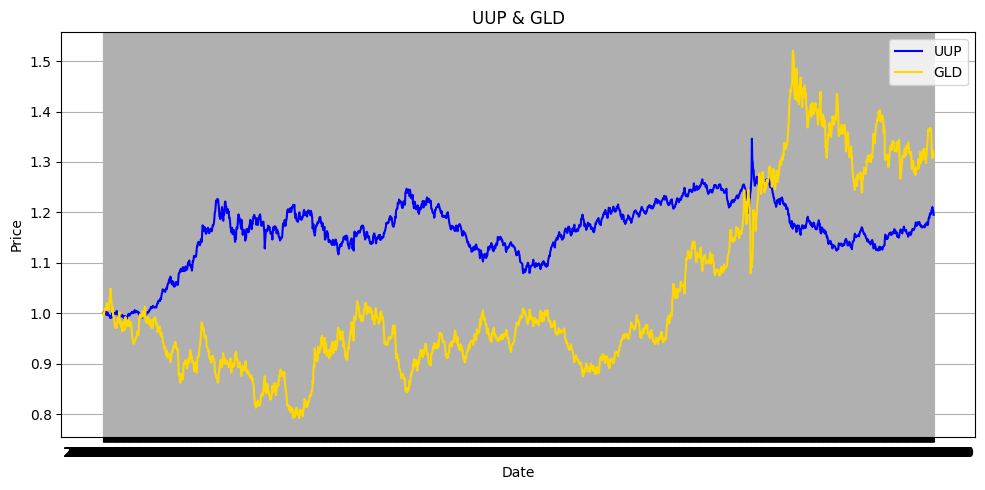

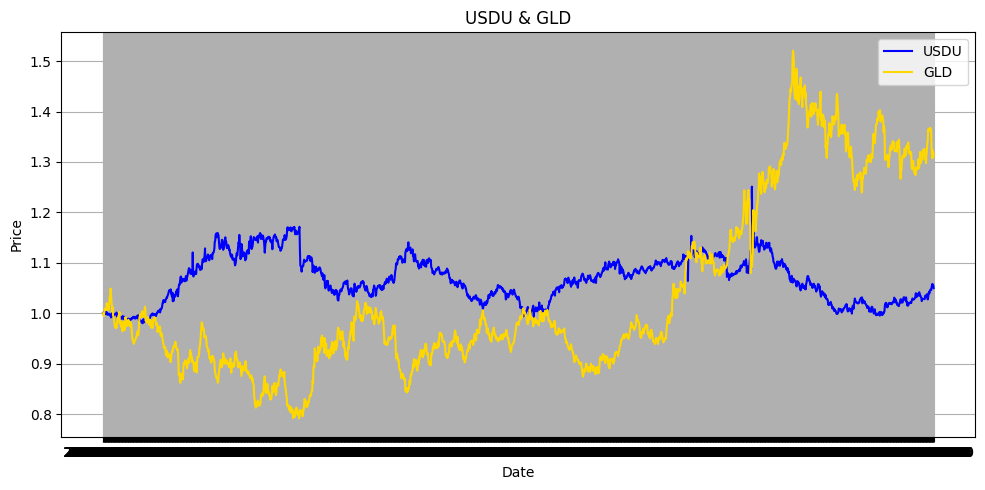

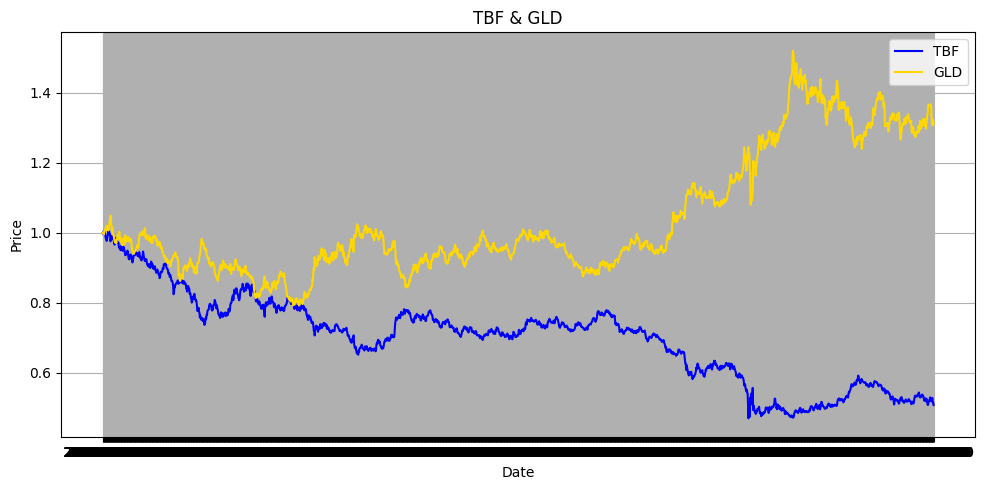

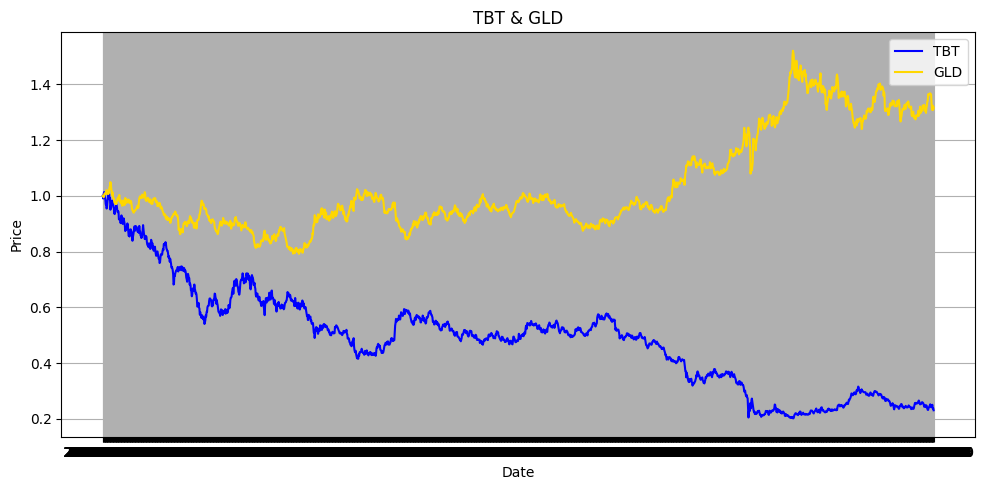

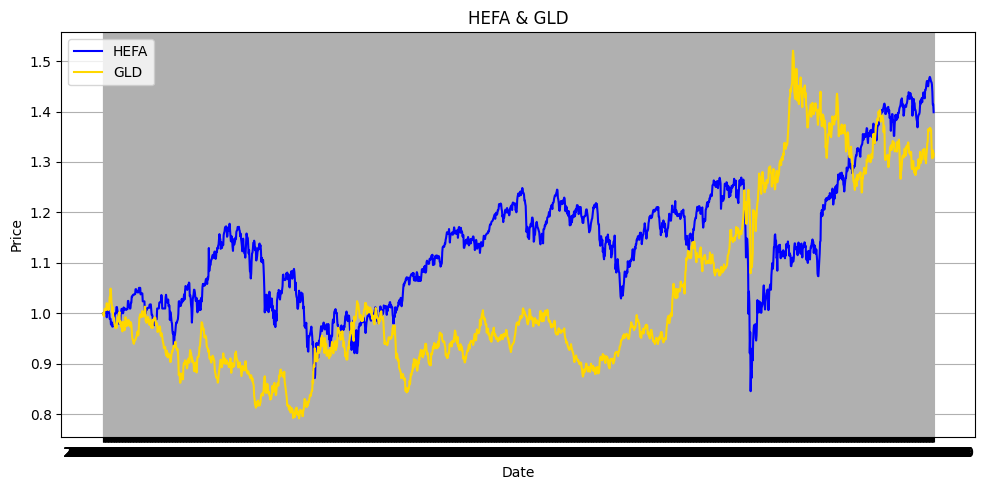

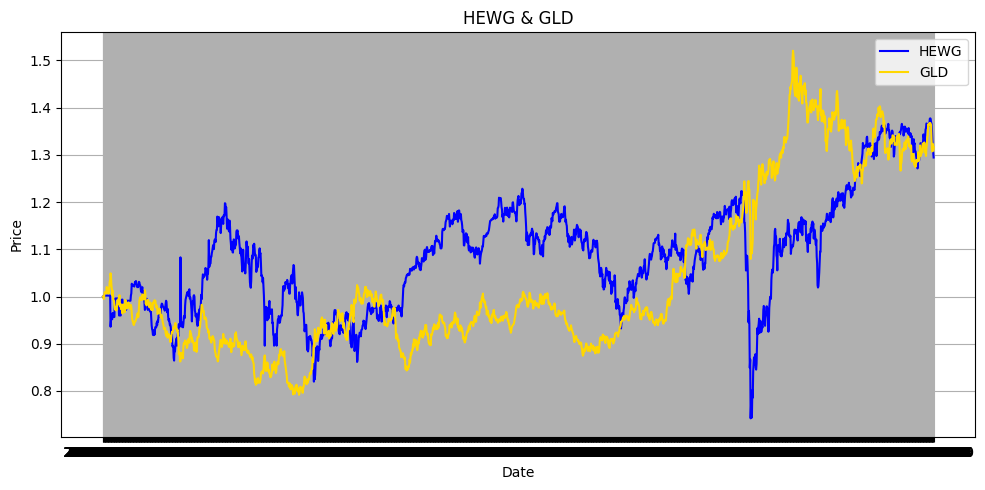

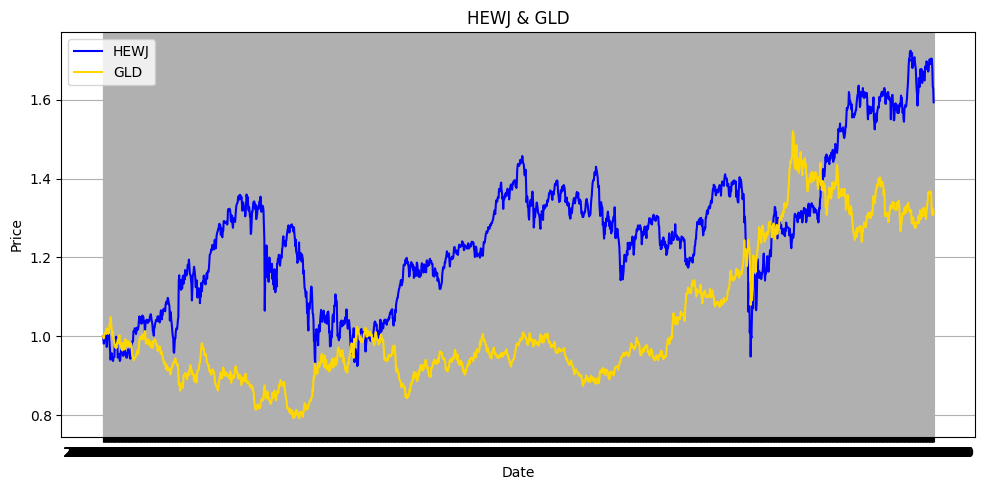

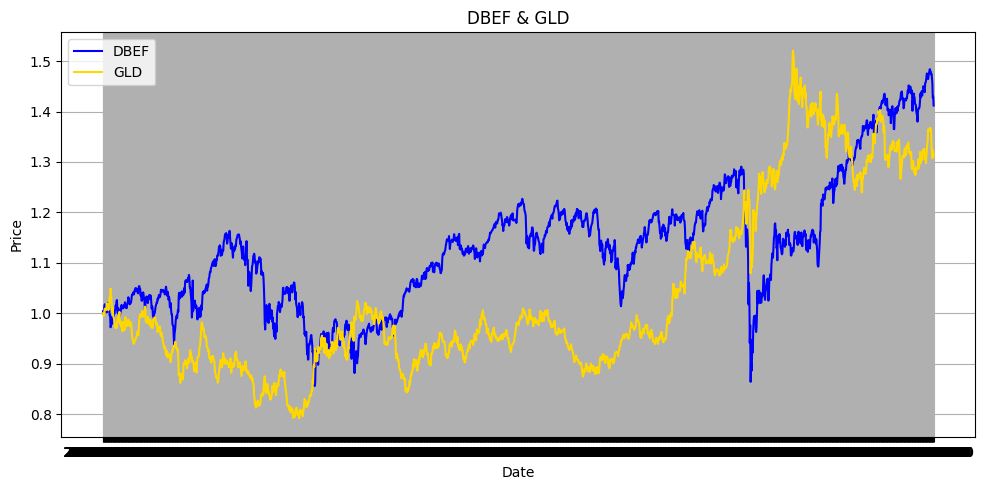

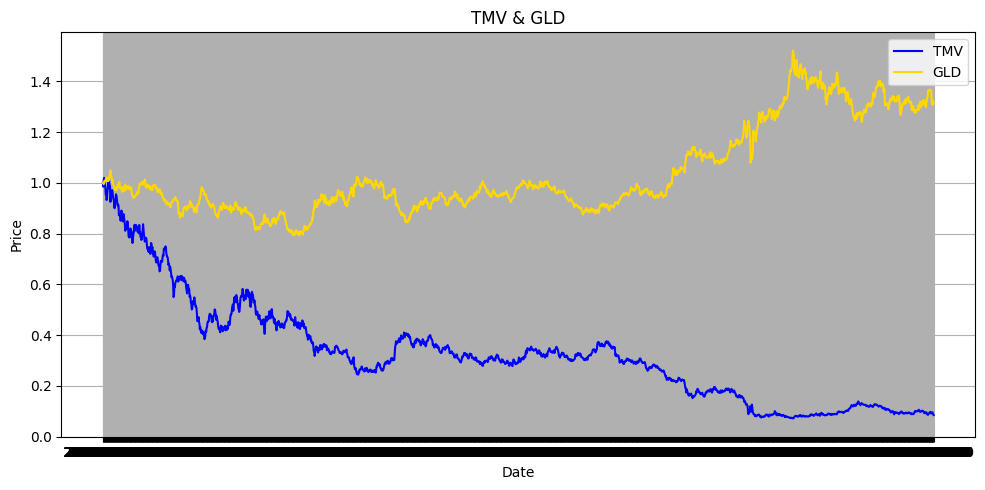

In [215]:
from matplotlib import pyplot as plt

# Now let's plot all tickers with GLD to see what they look like
tickers = [t for t in tickers if t != "GLD"]
for ticker in tickers:
    plt.figure(figsize=(10, 5))
    plt.plot(merged["price_date"], merged[ticker], label=ticker, color="blue")
    plt.plot(merged["price_date"], merged["GLD"], label="GLD", color="gold")
    plt.title(f"{ticker} & GLD")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"images/{ticker}_vsgold.png")
    plt.show()

It is possible to see from these graphs that most of the blue lines do show some symettry with the golden line, proving that they can indeed be hedges.

Let us find the best hedges by way of feature selection, and analysing the interpretability of the models.

What we were actually looking for here though is the difference compared to the baseline (price at first time point). Let us also convert the data to that.

In [216]:
for ticker in tickers + ["GLD"]:
    merged[ticker] -= 1.0
merged

,UUP,price_date,USDU,TBF,TBT,HEFA,HEWG,HEWJ,DBEF,TMV,GLD
0,0.000000,2014-02-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000466,2014-02-19,0.000400,-0.004803,-0.009524,0.000809,0.000810,-0.005381,0.005576,-0.015447,-0.001256
2,0.003262,2014-02-20,0.002799,0.003522,0.006303,0.000809,-0.002834,-0.018626,0.003717,0.009654,-0.005258
3,0.004194,2014-02-21,0.003199,0.006404,0.013445,0.000809,0.002024,-0.014901,0.011896,0.019308,0.001177
4,0.002796,2014-02-24,0.001200,-0.000320,-0.000980,0.000809,0.002024,0.004553,0.017472,-0.001609,0.008554
...,...,...,...,...,...,...,...,...,...,...,...
1957,0.206431,2021-11-23,0.055178,-0.475825,-0.752381,0.453258,0.353846,0.699089,0.466914,-0.905680,0.312824
1958,0.210624,2021-11-24,0.058377,-0.472302,-0.749300,0.438689,0.332794,0.678394,0.455762,-0.903685,0.307330
1959,0.202703,2021-11-26,0.054778,-0.486391,-0.762465,0.414002,0.310526,0.632864,0.427509,-0.911504,0.323183
1960,0.203635,2021-11-29,0.056377,-0.484470,-0.761064,0.414407,0.304858,0.629139,0.429740,-0.910973,0.309371


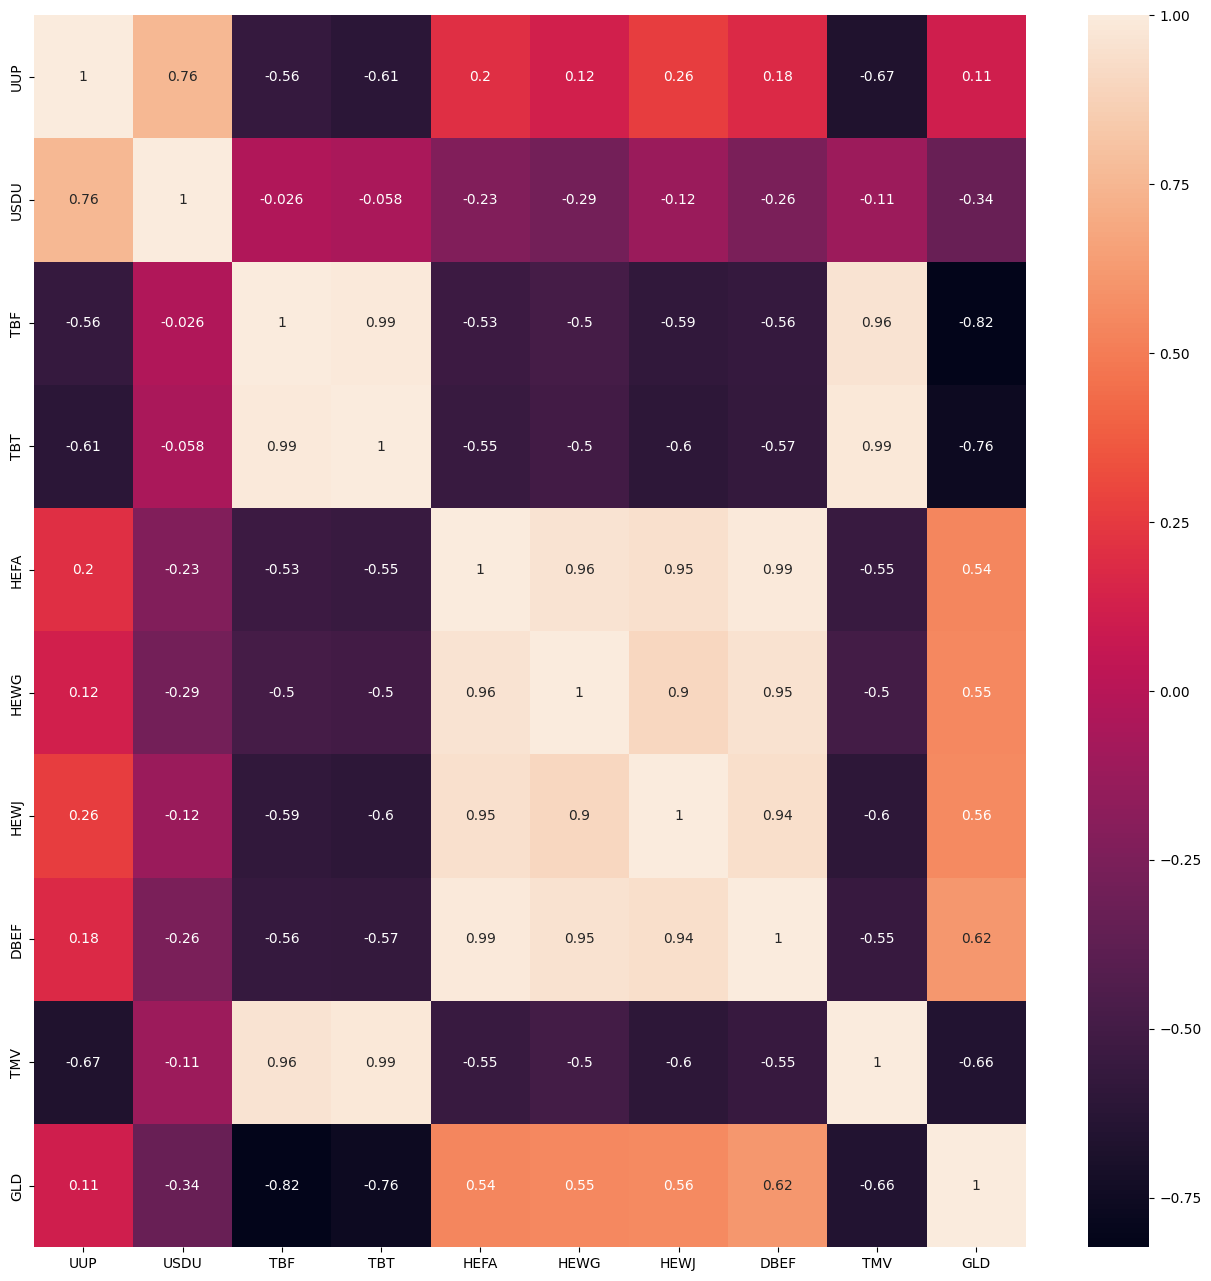

In [217]:
# View the correlation matrix
import seaborn as sns

plt.figure(figsize=(16,16))
f = sns.heatmap(merged.drop(["price_date"],axis=1,inplace=False).corr(), xticklabels=True, annot=True)
f.get_figure().savefig("images/heatmap.png")

Here we can see some tickers are highly correlated, so we can remove some of them

TBF, TBT and TMV are all correlated over 95 percent, so we can just include TBF

Let us just use TMV

Also, the four letter tickers show a high degree of correlation, so we can just use HEFA


In [218]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged.drop(["price_date", "GLD"],axis=1), merged["GLD"], test_size=0.2)

df_train = X_train.copy(True)
df_train["GLD"] = y_train




Let us first try using models that have no interaction


In [219]:
import statsmodels.formula.api as smf

model_str = "GLD ~ "
for ticker in tickers:
    model_str += ticker
    if ticker != tickers[-1]:
        model_str += "+ "
print(model_str)

model = smf.ols(formula=model_str, data=df_train).fit()
model.save("models/baseline.pickle")
model.summary()

GLD ~ UUP+ USDU+ TBF+ TBT+ HEFA+ HEWG+ HEWJ+ DBEF+ TMV


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     4327.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:34:02   Log-Likelihood:                 3084.2
No. Observations:                1569   AIC:                            -6148.
Df Residuals:                    1559   BIC:                            -6095.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0060      0.005     -1.169      0.243      -0.016       0.004
UUP            0.0714      0.062      1.146      0.252      -0.051       0.194
USDU          -0.7436      0.066    -11.345      0.000      -0.872      -0.615
TBF           -1.5407      0.368     -4.183      0.000      -2.263      -0.818
TBT           -1.2342      0.429     -2.877      0.004      -2.076      -0.393
HEFA          -1.1986      0.102    -11.732      0.000      -1.399      -0.998
HEWG           0.1489      0.029      5.115      0.000       0.092       0.206
HEWJ           0.0896      0.020      4.511      0.000       0.051       0.129
DBEF           1.1390      0.093     12.245      0.000       0.957       1.321
TMV            1.5357      0.168      9.141      0.000       1.206       1.865
==============================================================================
Omnibus:                       14.735   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.293
Skew:                           0.036   Prob(JB):                     1.44e-05
Kurtosis:                       3.579   Cond. No.                         969.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is the baseline model, let us see how it compares when we remove highly correlated values.

In [220]:
tickers_new = ["UUP", "USDU", "TMV", "HEFA"]

model_str = "GLD ~ "
for ticker in tickers_new:
    model_str += ticker
    if ticker != tickers_new[-1]:
        model_str += "+ "
print(model_str)

model = smf.ols(formula=model_str, data=df_train).fit()
model.summary()

GLD ~ UUP+ USDU+ TMV+ HEFA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     670.7
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:34:02   Log-Likelihood:                 1312.4
No. Observations:                1569   AIC:                            -2615.
Df Residuals:                    1564   BIC:                            -2588.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2959      0.010    -28.604      0.000      -0.316      -0.276
UUP           -1.8139      0.153    -11.823      0.000      -2.115      -1.513
USDU           0.2730      0.161      1.694      0.090      -0.043       0.589
TMV           -0.8631      0.031    -27.872      0.000      -0.924      -0.802
HEFA           0.1997      0.028      7.055      0.000       0.144       0.255
==============================================================================
Omnibus:                       53.896   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.730
Skew:                           0.469   Prob(JB):                     1.77e-13
Kurtosis:                       2.861   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

USDU has high statistical insignificance, P>t > 0.05 - so we can just use three of these tickers, and then add their interactions.

Note that in the baseline UUP was the one w/ high P>t , but as UUP and USDU have high correlation (>0.75), we can assume it is fine to choose just one of them.

In [221]:
tickers_new = ["UUP", "TMV", "HEFA"]

model_str = "GLD ~ "
for ticker in tickers_new:
    model_str += ticker
    if ticker != tickers_new[-1]:
        model_str += "+ "
print(model_str)

model = smf.ols(formula=model_str, data=df_train).fit()
model.summary()

GLD ~ UUP+ TMV+ HEFA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     892.3
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:34:02   Log-Likelihood:                 1311.0
No. Observations:                1569   AIC:                            -2614.
Df Residuals:                    1565   BIC:                            -2592.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2889      0.010    -30.399      0.000      -0.308      -0.270
UUP           -1.5744      0.060    -26.437      0.000      -1.691      -1.458
TMV           -0.8253      0.021    -38.420      0.000      -0.867      -0.783
HEFA           0.1860      0.027      6.853      0.000       0.133       0.239
==============================================================================
Omnibus:                       53.485   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.005
Skew:                           0.464   Prob(JB):                     2.54e-13
Kurtosis:                       2.834   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears UUP and TMV are good hedge candidates, let us add the interactions as well.

In [222]:
tickers_new = ["UUP", "TMV", "HEFA"]

model_str = "GLD ~ "
for ticker in tickers_new:
    model_str += ticker
    model_str += "+ "
model_str += "*".join(tickers_new)
print(model_str)

model = smf.ols(formula=model_str, data=df_train).fit()
model.save("models/final.pickle")
model.summary()

GLD ~ UUP+ TMV+ HEFA+ UUP*TMV*HEFA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1397.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:34:02   Log-Likelihood:                 2084.5
No. Observations:                1569   AIC:                            -4153.
Df Residuals:                    1561   BIC:                            -4110.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0102      0.008     -1.239      0.216      -0.026       0.006
UUP             -3.6572      0.102    -35.974      0.000      -3.857      -3.458
TMV             -0.0927      0.025     -3.680      0.000      -0.142      -0.043
HEFA            -2.6818      0.271     -9.897      0.000      -3.213      -2.150
UUP:TMV         -4.7446      0.140    -34.001      0.000      -5.018      -4.471
UUP:HEFA         9.0010      1.816      4.957      0.000       5.439      12.563
TMV:HEFA        -4.2664      0.333    -12.829      0.000      -4.919      -3.614
UUP:TMV:HEFA    15.1208      2.196      6.885      0.000      10.813      19.429
==============================================================================
Omnibus:                      326.349   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              613.144
Skew:                           1.254   Prob(JB):                    7.20e-134
Kurtosis:                       4.757   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let us interpret the model results. We can now see meaningful P>t values as well as coefficients that are negative (which previously was not the case!).

The three tickers UUP, TMV and HEFA can be reasonably considered for hedging against gold.
The other ones are very highly correlated with some others and therefore would be unnecessary.

Let us also try using all the values except the statistically insignificant USDU, and add their variations to check out the coefficients.

In [223]:
tickers_new = ["UUP", "TMV", "HEFA", "TBF", "TBT", "HEWJ", "DBEF", "HEWG"]

model_str = "GLD ~ "
for ticker in tickers_new:
    model_str += ticker
    model_str += "+ "
model_str += "*".join(tickers_new)
print(model_str)

model = smf.ols(formula=model_str, data=df_train).fit()
model.summary()

GLD ~ UUP+ TMV+ HEFA+ TBF+ TBT+ HEWJ+ DBEF+ HEWG+ UUP*TMV*HEFA*TBF*TBT*HEWJ*DBEF*HEWG


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     941.7
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:34:03   Log-Likelihood:                 4619.4
No. Observations:                1569   AIC:                            -8727.
Df Residuals:                    1313   BIC:                            -7355.
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0103      0.009      1.088      0.277      -0.008       0.029
UUP                                    -6.6979      1.542     -4.344      0.000      -9.723      -3.673
TMV                                     3.1898      3.513      0.908      0.364      -3.702      10.081
HEFA                                    0.1779      1.642      0.108      0.914      -3.044       3.400
TBF                                    -5.9758     15.628     -0.382      0.702     -36.635      24.683
TBT                                    -1.6428     10.867     -0.151      0.880     -22.961      19.676
HEWJ                                   -0.4512      0.506     -0.892      0.373      -1.443       0.541
DBEF                                   -0.1656      1.101     -0.150      0.880      -2.325       1.994
HEWG                                    3.5144      1.433      2.453      0.014       0.704       6.325
UUP:TMV                                42.7489     60.405      0.708      0.479     -75.753     161.250
UUP:HEFA                             -686.8865    125.188     -5.487      0.000    -932.477    -441.296
TMV:HEFA                             -203.5735    290.778     -0.700      0.484    -774.013     366.866
UUP:TMV:HEFA                        -3658.1771   2389.211     -1.531      0.126   -8345.264    1028.910
UUP:TBF                               973.4739    366.523      2.656      0.008     254.439    1692.509
TMV:TBF                                56.7692     74.136      0.766      0.444     -88.669     202.208
UUP:TMV:TBF                          1086.9020    740.006      1.469      0.142    -364.822    2538.626
HEFA:TBF                            -2349.8383   1043.896     -2.251      0.025   -4397.726    -301.951
UUP:HEFA:TBF                        -3.785e+04   1.45e+04     -2.605      0.009   -6.64e+04   -9342.693
TMV:HEFA:TBF                         -1.11e+04   4023.482     -2.759      0.006    -1.9e+04   -3208.961
UUP:TMV:HEFA:TBF                     -1.03e+04    2.7e+04     -0.382      0.703   -6.32e+04    4.26e+04
UUP:TBT                              -588.9009    271.286     -2.171      0.030   -1121.102     -56.700
TMV:TBT                               -14.8262     25.766     -0.575      0.565     -65.374      35.721
UUP:TMV:TBT                          -590.9054    285.699     -2.068      0.039   -1151.382     -30.428
HEFA:TBT                             1516.5544    765.630      1.981      0.048      14.562    3018.547
UUP:HEFA:TBT                         1.949e+04   1.04e+04      1.875      0.061    -902.843    3.99e+04
TMV:HEFA:TBT                         3699.7838   1366.066      2.708      0.007    1019.874    6379.694
UUP:TMV:HEFA:TBT                     8420.3840   1.03e+04      0.81

There is high R2 but a lot of these coefficients likely need regularization, not to mention that some are positive next to prices, which should not make sense according to our exploratory data analysis and finance knowlegde.
Same is true for the baseline model.

We conclude we have a better model to predict GLD price using hedges and have shown TMV, UUP, HEFA to be pretty decent hedges, confirming our knowledge of the markets.

**Testing or the TMV, UUP, HEFA model**

In [227]:
tickers_new = ["UUP", "TMV", "HEFA"]

model_str = "GLD ~ "
for ticker in tickers_new:
    model_str += ticker
    model_str += "+ "
model_str += "*".join(tickers_new)
print(model_str)

model = smf.ols(formula=model_str, data=df_train).fit()
model.summary()

GLD ~ UUP+ TMV+ HEFA+ UUP*TMV*HEFA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GLD   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1397.
Date:                Mon, 23 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:35:06   Log-Likelihood:                 2084.5
No. Observations:                1569   AIC:                            -4153.
Df Residuals:                    1561   BIC:                            -4110.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0102      0.008     -1.239      0.216      -0.026       0.006
UUP             -3.6572      0.102    -35.974      0.000      -3.857      -3.458
TMV             -0.0927      0.025     -3.680      0.000      -0.142      -0.043
HEFA            -2.6818      0.271     -9.897      0.000      -3.213      -2.150
UUP:TMV         -4.7446      0.140    -34.001      0.000      -5.018      -4.471
UUP:HEFA         9.0010      1.816      4.957      0.000       5.439      12.563
TMV:HEFA        -4.2664      0.333    -12.829      0.000      -4.919      -3.614
UUP:TMV:HEFA    15.1208      2.196      6.885      0.000      10.813      19.429
==============================================================================
Omnibus:                      326.349   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              613.144
Skew:                           1.254   Prob(JB):                    7.20e-134
Kurtosis:                       4.757   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [231]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2 Score:", r2)


MSE: 0.004300728184501747
R2 Score: 0.8611214963751934


The MSE is around 0.4% which is meaningful given that gold rises from 0-40% in the given timespan.
R2 is also good, as above 85% is considered a good prediction in finance.

It would therefore make sense to propose investing in TMV - a treasury bearish ETF and UUP - a US dollar bullish ETF. Also reasonable to invest in a indirectly USD bullish market such as Germany or Japan (HEFA).

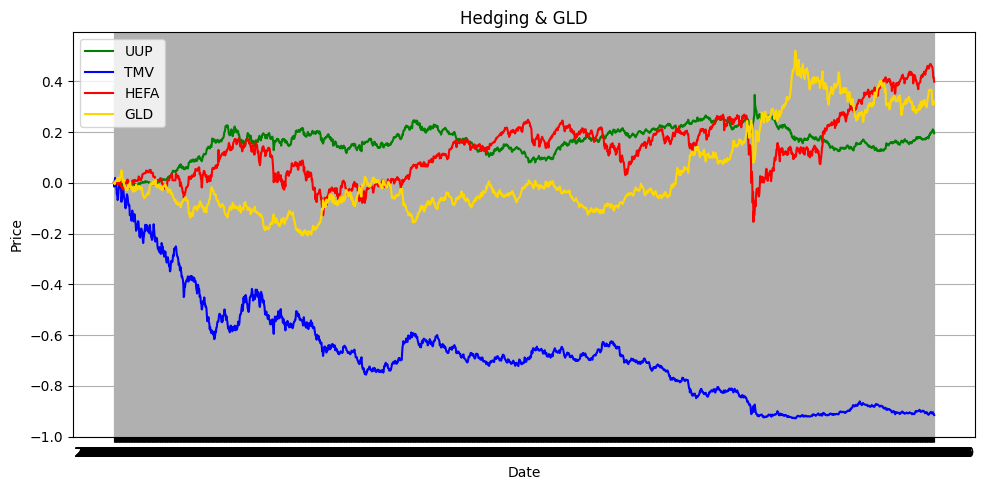

In [226]:
# Saving an displaying a plot of prices for UUP, TMV and HEFA vs GLD

plt.figure(figsize=(10, 5))
plt.plot(merged["price_date"], merged["UUP"], label="UUP", color="green")
plt.plot(merged["price_date"], merged["TMV"], label="TMV", color="blue")
plt.plot(merged["price_date"], merged["HEFA"], label="HEFA", color="red")
plt.plot(merged["price_date"], merged["GLD"], label="GLD", color="gold")
plt.title("Hedging & GLD")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"images/hedges_vsgold.png")
plt.show()

**Links**

Data source: https://www.kaggle.com/datasets/stefanoleone992/mutual-funds-and-etfs?resource=download
GitHub repo: https://github.com/TuteskoSarcaf/ml1-proj#